# 

<div style="background-color: #ff9800; border-radius: 20px 0 20px 0; padding: 15px; border-left: 5px solid #f57c00; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <p style="font-family: 'Arial', sans-serif;font-size: 20px; color: white;">Installing and importing Required Libraries</p>
</div>


In [20]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm

<div style="background-color: #ff9800; border-radius: 20px 0 20px 0; padding: 15px; border-left: 5px solid #f57c00; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <p style="font-family: 'Arial', sans-serif;font-size: 20px; color: white;">Loading AffectNEt Data for finetuning</p>
</div>

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
base_dir = '/kaggle/input/affectnet-training-data'

dataset = datasets.ImageFolder(root=base_dir, transform=transform)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

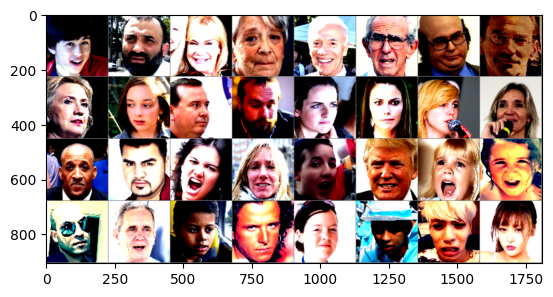

In [21]:
def imshow(img):
    """Helper function to display an image."""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(make_grid(images))

<div style="background-color: #ff9800; border-radius: 20px 0 20px 0; padding: 15px; border-left: 5px solid #f57c00; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <p style="font-family: 'Arial', sans-serif;font-size: 20px; color: white;">Loading Pretrained VGG Model </p>
</div>

In [6]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 8)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s] 


In [7]:
device = 'cuda'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<div style="background-color: #ff9800; border-radius: 20px 0 20px 0; padding: 15px; border-left: 5px solid #f57c00; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <p style="font-family: 'Arial', sans-serif;font-size: 20px; color: white;">Training Model </p>
</div>

In [12]:
num_epochs = 10

In [13]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', unit='batch'):
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/10: 100%|██████████| 727/727 [01:59<00:00,  6.08batch/s]


Epoch 1/10, Loss: 0.0962


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.24batch/s]


Validation Accuracy: 0.6557


Epoch 2/10: 100%|██████████| 727/727 [01:59<00:00,  6.09batch/s]


Epoch 2/10, Loss: 0.0899


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.21batch/s]


Validation Accuracy: 0.6721


Epoch 3/10: 100%|██████████| 727/727 [01:59<00:00,  6.09batch/s]


Epoch 3/10, Loss: 0.0806


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.22batch/s]


Validation Accuracy: 0.6721


Epoch 4/10: 100%|██████████| 727/727 [02:00<00:00,  6.04batch/s]


Epoch 4/10, Loss: 0.0685


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.14batch/s]


Validation Accuracy: 0.6771


Epoch 5/10: 100%|██████████| 727/727 [01:58<00:00,  6.12batch/s]


Epoch 5/10, Loss: 0.0761


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.46batch/s]


Validation Accuracy: 0.6604


Epoch 6/10: 100%|██████████| 727/727 [01:59<00:00,  6.11batch/s]


Epoch 6/10, Loss: 0.0721


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.17batch/s]


Validation Accuracy: 0.6769


Epoch 7/10: 100%|██████████| 727/727 [01:59<00:00,  6.09batch/s]


Epoch 7/10, Loss: 0.0584


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.14batch/s]


Validation Accuracy: 0.6548


Epoch 8/10: 100%|██████████| 727/727 [01:59<00:00,  6.09batch/s]


Epoch 8/10, Loss: 0.0646


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.19batch/s]


Validation Accuracy: 0.6678


Epoch 9/10: 100%|██████████| 727/727 [01:58<00:00,  6.12batch/s]


Epoch 9/10, Loss: 0.0561


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.27batch/s]


Validation Accuracy: 0.6676


Epoch 10/10: 100%|██████████| 727/727 [01:59<00:00,  6.10batch/s]


Epoch 10/10, Loss: 0.0496


Validation: 100%|██████████| 182/182 [00:19<00:00,  9.39batch/s]

Validation Accuracy: 0.6638


In [14]:
torch.save(model.state_dict(), 'vgg_affectnet.pth')

<div style="background-color: #ff9800; border-radius: 20px 0 20px 0; padding: 15px; border-left: 5px solid #f57c00; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <p style="font-family: 'Arial', sans-serif;font-size: 20px; color: white;">Validation and Classification Report for val_loader </p>
</div>

In [16]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [17]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report for Validation Set:")
print(report)

Classification Report for Validation Set:
              precision    recall  f1-score   support

       anger       0.47      0.47      0.47       632
    contempt       0.65      0.57      0.61       568
     disgust       0.44      0.54      0.49       464
        fear       0.57      0.54      0.55       691
       happy       0.94      0.87      0.91       992
     neutral       0.84      0.93      0.88      1026
         sad       0.51      0.55      0.53       622
    surprise       0.61      0.56      0.58       814

    accuracy                           0.66      5809
   macro avg       0.63      0.63      0.63      5809
weighted avg       0.67      0.66      0.66      5809

